In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.layers import (Conv1D, Dense, Flatten, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [2]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 4.0 MB/s 


In [3]:
import pickle5

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing dataset
ds = '/content/drive/MyDrive/pcd_dataset.pickle'

In [6]:
infile = open(ds,'rb')
dataset = pickle5.load(infile)
infile.close()

In [7]:
input = np.array(dataset['Y'])
gt = np.array(dataset['X'])

In [8]:
class EncoderDecoder(Model):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            Conv1D(128, kernel_size=1),
            Conv1D(256, kernel_size=1),
            Conv1D(512, kernel_size=1),
            #Conv1D(1000, kernel_size=1),
            Flatten(),
            Dense(1000)
        ])
        self.decoder = tf.keras.Sequential([
            Dense(1000, activation=None),
            Dense(1000, activation=None),
            Dense(2000*3, activation=None),
            Reshape((2000, 3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

In [10]:
model1 = EncoderDecoder()

In [11]:
model1.compile(optimizer='adam', loss=euc_dist_keras, metrics = ['accuracy'])

In [ ]:
!pip install livelossplot

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [14]:
def train_model(X, y, model, numEpoch, nameFile):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=25, verbose=0, mode='min',
                                   restore_best_weights= True)
    callbacks = [PlotLossesCallback(), early_stopping]
    hist = model.fit(X, y, batch_size=32, verbose=1, epochs=numEpoch, validation_split=0.2, 
                    callbacks = callbacks)
    model.save_weights(nameFile, save_format='h5')
    return hist

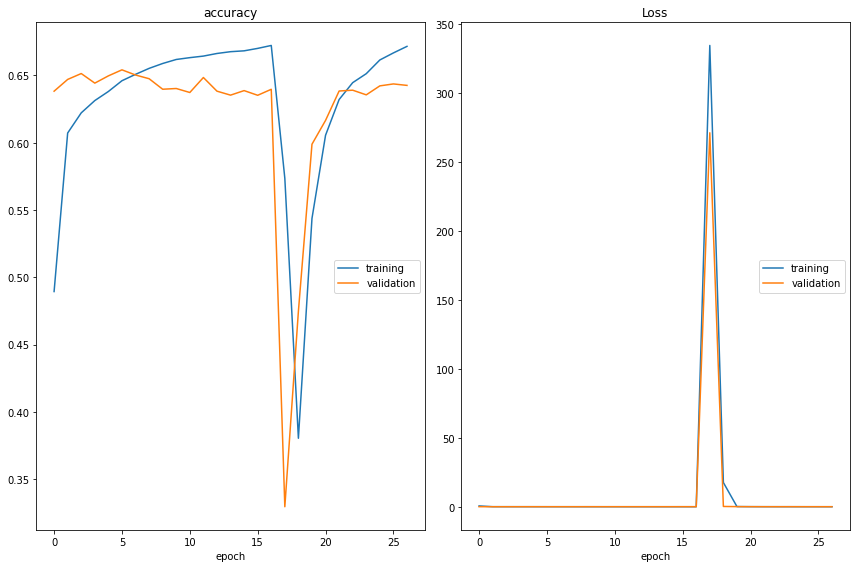

accuracy
	training         	 (min:    0.380, max:    0.672, cur:    0.672)
	validation       	 (min:    0.329, max:    0.654, cur:    0.643)
Loss
	training         	 (min:    0.283, max:  334.446, cur:    0.283)
	validation       	 (min:    0.302, max:  271.193, cur:    0.318)
120/120 [==============================] - 10s 85ms/step - loss: 0.2827 - accuracy: 0.6716 - val_loss: 0.3176 - val_accuracy: 0.6426


In [15]:
train_model(input, gt, model1, 100, '/content/drive/MyDrive/modelSaved')

In [ ]:
!pip install open3d

In [19]:
import open3d as o3d

In [18]:
#inference
def inferr(model, weight, inference_file):
  mesh = o3d.io.read_triangle_mesh(inference_file)
  pcd = mesh.sample_points_uniformly(number_of_points = 1000)
  pcd_array = np.asarray(pcd.points)
  model.load_weights(weight)
  pcd_input = np.expand_dims(pcd_array, axis=0)
  predicted_array = model.predict()
  output = predicted_array[0]
  pcd_output = o3d.o3d.geometry.PointCloud()
  pcd_output = o3d.utility.Vector3dVector(output)
  o3d.io.write_point_cloud("output.ply", pcd)
  radii = [0.005, 0.01, 0.02, 0.04]
  rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd_output, o3d.utility.DoubleVector(radii))
  o3d.io.write_triangle_mesh("copy_of_knot.obj", rec_mesh)
  return pcd_output, rec_mesh

NotImplementedError: ignored